In [141]:
print("Starting setups...")
import sys
import os

dir_path = os.getcwd()
parent_dir = os.path.dirname(dir_path)
home_dir = os.path.dirname(parent_dir)
print("dir_path is", dir_path)
print("parent_dir is", parent_dir)
print("home_dir is", home_dir)

import yaml
print(home_dir+'/params.yaml')
with open(home_dir+'/params.yaml', 'r') as file:
    params = yaml.safe_load(file)
print('params:', params)

data_folder = home_dir+params['data_location']
print('Data is stored at', data_folder)

with open(dir_path+"/params.yaml", "r") as file:
    config = yaml.safe_load(file)

print(f"Current configuration is: {config}")

Starting setups...
dir_path is /Users/zoe/Documents/Bank-account-fraud/code/model_tuning
parent_dir is /Users/zoe/Documents/Bank-account-fraud/code
home_dir is /Users/zoe/Documents/Bank-account-fraud
/Users/zoe/Documents/Bank-account-fraud/params.yaml
params: {'data_location': '/data', 'output_location': '/output', 'code_location': '/code'}
Data is stored at /Users/zoe/Documents/Bank-account-fraud/data
Current configuration is: {'tuning': {'method': 'random_search', 'random_search': {'param_distributions': {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}, 'n_iter': 50, 'cv': 3, 'scoring': 'roc_auc', 'random_state': 42}, 'grid_search': {'param_grid': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 6, 9], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}, 'cv': 5, 'scoring': 'roc_auc'}, 'bayesian_optimization':

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings as wr
wr.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier

# sys.path.append(os.path.abspath("model_tuning"))
# from functions import *

In [131]:
pd.set_option('display.max_rows', 500)


# function to get all evaluation metrics

In [6]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(model, 
                               X_test, y_test, 
                               threshold=0.5, 
                               plot_roc_curve=False, 
                               plot_pr_curve=False,
                               plot_confusion_matrix=False,
                              ):
    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    preds = model.predict(dtest)
    auc_score = roc_auc_score(y_test, preds)
    # Classify based on the threshold
    pred_bool = (preds >= threshold).astype(int)
    
    # Compute confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_test, pred_bool).ravel()
    cm = confusion_matrix(y_test, pred_bool)
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    # Compute ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(y_test, preds)
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc_score = auc(recall, precision)
    
    # Print the results
    print(f"Recall (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f'ROC AUC: {auc_score:.5f}')
    print(f'PR AUC: {pr_auc_score:.5f}')

    # Plot Precision-Recall curve if enabled
    if plot_pr_curve:
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', label=f'PR AUC = {pr_auc_score:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()
    
    # Plot ROC curve if enabled
    if plot_roc_curve:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_curve, tpr_curve, color='blue', label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guess')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
    
    # Plot confusion matrix if enabled
    if plot_confusion_matrix:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    return {
        "PREDS": preds, 
        "PREDS_BOOL": pred_bool, 
        "TN": tn, 
        "FP": fp, 
        "FN": fn, 
        "TP": tp, 
        "TPR": tpr,
        "FPR": fpr,
        "ROC AUC": auc_score,
        "Confusion Matrix": cm,
        "ROC Curve": (fpr_curve, tpr_curve),
        "PRECISION": precision
    }

In [8]:
def fit_model(best_params, dtrain, dtest):
    # Train the final model with the best hyperparameters
    model = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=5,
        evals=[(dtrain, 'training'), (dtest, 'testing')],
        maximize=True,
        verbose_eval=2
    )
    return model

In [7]:
def objective(hyperparameters, dtrain, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Perform n_folds cross validation
    cv_results = xgb.cv(params = hyperparameters, 
                        dtrain = dtrain, 
                        num_boost_round = 10000, nfold = 10, 
                        early_stopping_rounds = 3, metrics = 'aucpr', 
                        seed = 111,
                        verbose_eval=2, maximize=True)
    
    # results to retun
    # score = cv_results['test-auc-mean'].max()
    # estimators = len(cv_results['test-auc-mean'])
    # hyperparameters['n_estimators'] = estimators 
    
    return cv_results

# Baseline model - with smoteNC

Assumptions:
1. imbalaned dataset with low percentage of positive cases, so we use AUC as the measuring metrics
2. assume it's more costly to have higher FN(misclassified fraud cases as not fraud) than higher FP (false alarm for not fraud as fraud). So we aim for a higher recall (higher true positive rate & lower false negative)

In [102]:
print("Reading training and test data...")
X_train = pd.read_csv(f"{home_dir}/data/x_train_data.csv", index_col=0)
y_train = pd.read_csv(f"{home_dir}/data/y_train_data.csv", index_col=0)
X_test = pd.read_csv(f"{home_dir}/data/x_test_data.csv", index_col=0)
y_test = pd.read_csv(f"{home_dir}/data/y_test_data.csv", index_col=0)

# X_train_smote = pd.read_csv(f"{parent_dir}/data/x_train_data_smote.csv", index_col=0)
# y_train_smote = pd.read_csv(f"{parent_dir}/data/y_train_data_smote.csv", index_col=0)

Reading training and test data...


In [103]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [104]:
default_model = XGBClassifier(eval_metric='aucpr')
default_params = default_model.get_params()
print(default_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [105]:
default_model = fit_model(default_params, dtrain, dtest)

[0]	training-aucpr:0.90208	testing-aucpr:0.05463
[2]	training-aucpr:0.93072	testing-aucpr:0.07367
[4]	training-aucpr:0.94441	testing-aucpr:0.08011
[6]	training-aucpr:0.95293	testing-aucpr:0.08335
[8]	training-aucpr:0.96176	testing-aucpr:0.08922
[10]	training-aucpr:0.97197	testing-aucpr:0.09446
[12]	training-aucpr:0.97415	testing-aucpr:0.09233
[14]	training-aucpr:0.97681	testing-aucpr:0.09480
[16]	training-aucpr:0.98254	testing-aucpr:0.09311


Recall (TPR): 0.5353
False Positive Rate (FPR): 0.0785
ROC AUC: 0.85671
PR AUC: 0.09307


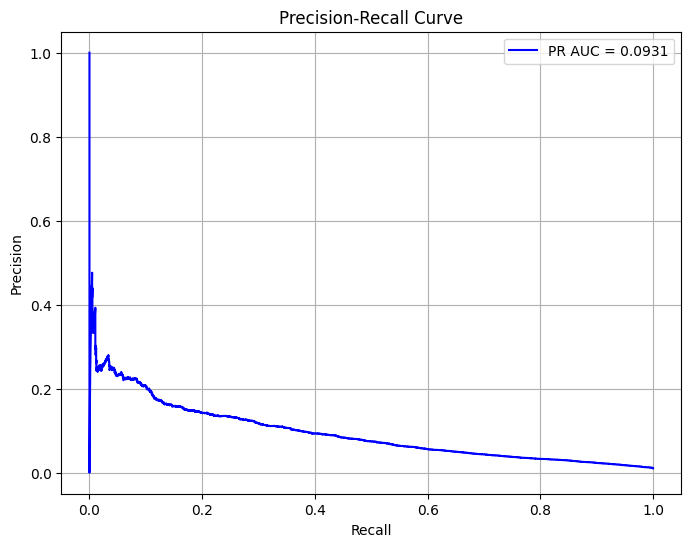

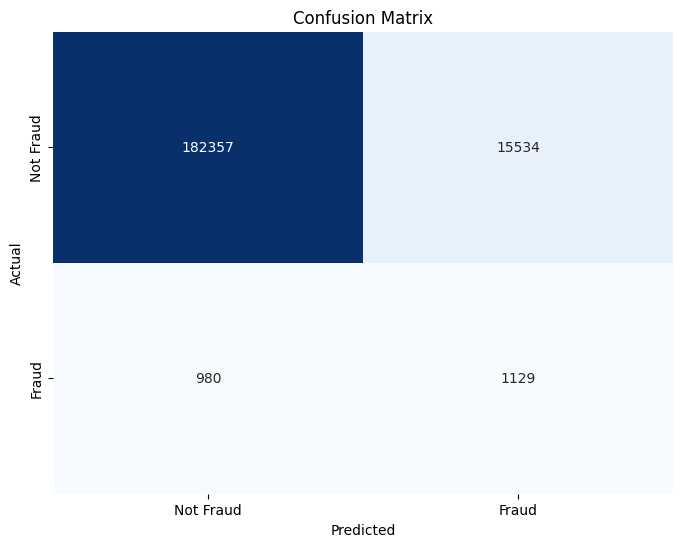

{'PREDS': array([0.04469398, 0.02625463, 0.01448133, ..., 0.03918775, 0.06242112,
       0.00857487], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(182357), 'FP': np.int64(15534), 'FN': np.int64(980), 'TP': np.int64(1129), 'TPR': np.float64(0.5353247984826932), 'FPR': np.float64(0.07849775886725521), 'ROC AUC': np.float64(0.8567140089206065), 'Confusion Matrix': array([[182357,  15534],
       [   980,   1129]]), 'ROC Curve': (array([0.00000000e+00, 1.01065738e-05, 1.51598607e-05, ...,
       9.99752389e-01, 9.99762496e-01, 1.00000000e+00]), array([0., 0., 0., ..., 1., 1., 1.])), 'PRECISION': array([0.010545  , 0.01054505, 0.01054511, ..., 0.        , 0.        ,
       1.        ])}


In [111]:
baseline_perfomance = evaluate_model_performance(default_model, 
                                              X_test, y_test, 
                                              threshold=0.4,
                                              plot_pr_curve=True, plot_confusion_matrix=True)
print(baseline_perfomance)

In [115]:
compare = pd.DataFrame({
    'y':y_test.fraud_bool,
    'y_hat':baseline_perfomance["PREDS_BOOL"]
})

compare[compare.y==1].sum()

y        2109
y_hat    1129
dtype: int64

In [13]:
feature_importance = default_model.get_score(fmap='', importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
feature_importance_df

,score
scaled_date_of_birth_distinct_emails_4w,88.0
scaled_prev_address_months_count,86.0
income,72.0
scaled_bank_branch_count_8w,72.0
device_os_windows,53.0
phone_home_valid,47.0
prev_address_months_count_was_missing,43.0
housing_status_BA,40.0
bank_months_count_binned,39.0
month,34.0


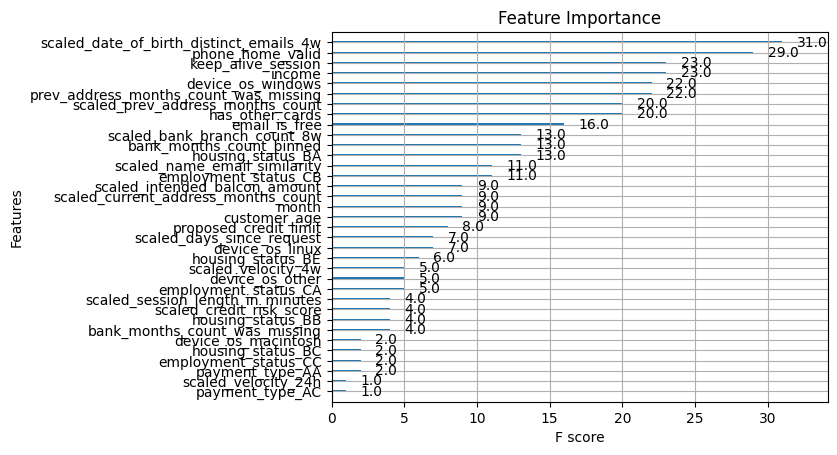

In [110]:
xgb.plot_importance(default_model, importance_type='weight', title='Feature Importance')
plt.show()

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to get the number of estimators.

how is the true negative different from the one's that are not captured as fraud;
exmaine the true negatives and go back to the features to alter the figure and let the model learn from new features 

# Baseline model2 - without ohe + smotenc; use xgboost enable_categorical and scale_pos_weight

In [116]:
print("Reading training and test data...")
X_train = pd.read_csv(f"{home_dir}/data/no_smote_ohe_x_train.csv", index_col=0)
y_train = pd.read_csv(f"{home_dir}/data/no_smote_ohe_y_train.csv", index_col=0)
X_test = pd.read_csv(f"{home_dir}/data/no_smote_ohe_x_test.csv", index_col=0)
y_test = pd.read_csv(f"{home_dir}/data/no_smote_ohe_y_test.csv", index_col=0)

# X_train_smote = pd.read_csv(f"{parent_dir}/data/x_train_data_smote.csv", index_col=0)
# y_train_smote = pd.read_csv(f"{parent_dir}/data/y_train_data_smote.csv", index_col=0)

Reading training and test data...


In [117]:
categorical_features = []
numerical_features = []

for x in X_train.columns: 
    if X_train[x].nunique() > 12:
        numerical_features.append(x)
    elif X_train[x].nunique() >=2:
        categorical_features.append(x)

categorical_features

['income',
 'customer_age',
 'payment_type',
 'employment_status',
 'email_is_free',
 'housing_status',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'month',
 'bank_months_count_was_missing',
 'prev_address_months_count_was_missing',
 'bank_months_count_binned']

In [118]:
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

In [119]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [120]:
default_model2 = XGBClassifier(eval_metric='aucpr', scale_pos_weight=89, enable_categorical=True)
default_params2 = default_model2.get_params()
print(default_params2)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': True, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 89, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [121]:
default_model2 = fit_model(default_params2, dtrain, dtest)

[0]	training-aucpr:0.07770	testing-aucpr:0.07013
[2]	training-aucpr:0.11351	testing-aucpr:0.09665
[4]	training-aucpr:0.12843	testing-aucpr:0.10532
[6]	training-aucpr:0.14481	testing-aucpr:0.12047
[8]	training-aucpr:0.15666	testing-aucpr:0.12924
[10]	training-aucpr:0.16762	testing-aucpr:0.13727
[12]	training-aucpr:0.17536	testing-aucpr:0.14222
[14]	training-aucpr:0.18175	testing-aucpr:0.14448
[16]	training-aucpr:0.18615	testing-aucpr:0.14701
[18]	training-aucpr:0.18966	testing-aucpr:0.14845
[20]	training-aucpr:0.19422	testing-aucpr:0.14928
[22]	training-aucpr:0.19849	testing-aucpr:0.14931
[24]	training-aucpr:0.20191	testing-aucpr:0.14937


Recall (TPR): 0.6060
False Positive Rate (FPR): 0.0759
ROC AUC: 0.88959
PR AUC: 0.14937


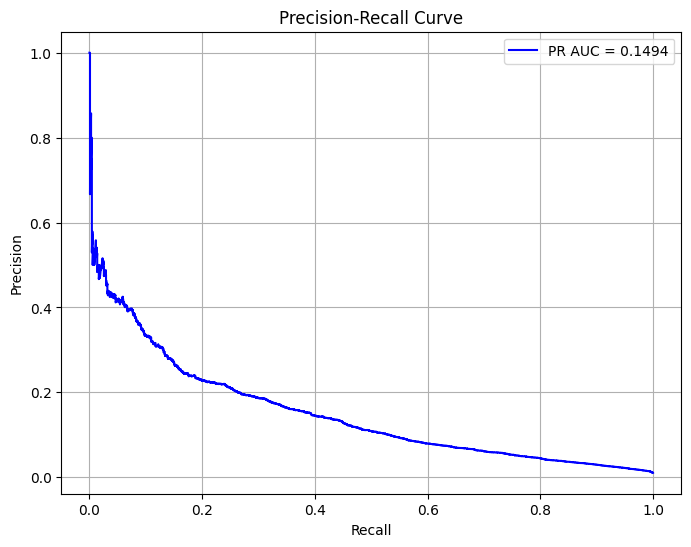

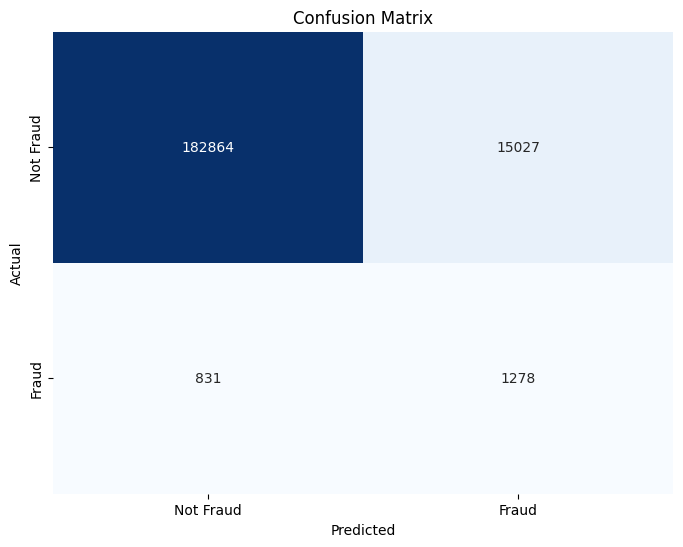

{'PREDS': array([0.06985774, 0.01987399, 0.0253904 , ..., 0.19705924, 0.10816745,
       0.0495311 ], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(182864), 'FP': np.int64(15027), 'FN': np.int64(831), 'TP': np.int64(1278), 'TPR': np.float64(0.6059743954480796), 'FPR': np.float64(0.07593574240364645), 'ROC AUC': np.float64(0.8895851071502527), 'Confusion Matrix': array([[182864,  15027],
       [   831,   1278]]), 'ROC Curve': (array([0.        , 0.        , 0.        , ..., 0.99437064, 0.99438074,
       1.        ]), array([0.00000000e+00, 4.74158369e-04, 9.48316738e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])), 'PRECISION': array([0.010545  , 0.01054505, 0.01054511, ..., 1.        , 1.        ,
       1.        ])}


In [122]:
baseline_perfomance = evaluate_model_performance(default_model2, 
                                              X_test, y_test, 
                                              threshold=0.7,
                                              plot_pr_curve=True, plot_confusion_matrix=True)
print(baseline_perfomance)

In [123]:
compare = pd.DataFrame({
    'y':y_test.fraud_bool,
    'y_hat':baseline_perfomance["PREDS_BOOL"]
})

compare[compare.y==1].sum()

y        2109
y_hat    1278
dtype: int64

In [124]:
feature_importance = default_model2.get_score(fmap='', importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
feature_importance_df

,score
income,104.0
bank_months_count_binned,98.0
scaled_current_address_months_count,95.0
scaled_credit_risk_score,87.0
scaled_name_email_similarity,86.0
month,80.0
scaled_intended_balcon_amount,74.0
housing_status,65.0
scaled_velocity_4w,57.0
scaled_zip_count_4w,56.0


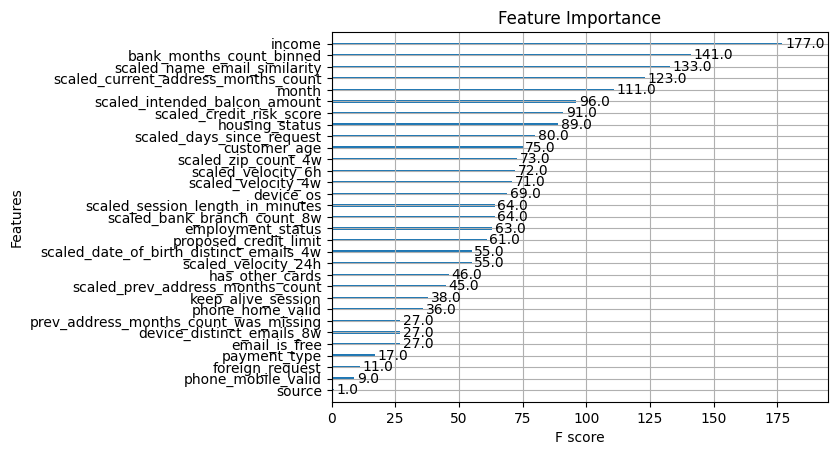

In [98]:
xgb.plot_importance(default_model2, importance_type='weight', title='Feature Importance')
plt.show()

# Baseline model3 - without smotenc; use xgboost scale_pos_weight

In [125]:
print("Reading training and test data...")
X_train = pd.read_csv(f"{home_dir}/data/no_smote_x_train.csv", index_col=0)
y_train = pd.read_csv(f"{home_dir}/data/no_smote_y_train.csv", index_col=0)
X_test = pd.read_csv(f"{home_dir}/data/no_smote_x_test.csv", index_col=0)
y_test = pd.read_csv(f"{home_dir}/data/no_smote_y_test.csv", index_col=0)

# X_train_smote = pd.read_csv(f"{parent_dir}/data/x_train_data_smote.csv", index_col=0)
# y_train_smote = pd.read_csv(f"{parent_dir}/data/y_train_data_smote.csv", index_col=0)

Reading training and test data...


In [126]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [127]:
# scale_pos_weight = count(negative examples)/count(Positive examples) or 

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()

weight_ratio = int(round(neg_count/ pos_count))
print("Weight Ratio:", weight_ratio)

default_model3 = XGBClassifier(scale_pos_weight=weight_ratio, eval_metric='aucpr')
default_params3 = default_model3.get_params()
print(default_params3)

Weight Ratio: 89
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 89, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [128]:
default_model3 = fit_model(default_params3, dtrain, dtest)

[0]	training-aucpr:0.07705	testing-aucpr:0.06989
[2]	training-aucpr:0.11203	testing-aucpr:0.09682
[4]	training-aucpr:0.12400	testing-aucpr:0.10526
[6]	training-aucpr:0.14074	testing-aucpr:0.11800
[8]	training-aucpr:0.15114	testing-aucpr:0.12651
[10]	training-aucpr:0.16011	testing-aucpr:0.13420
[12]	training-aucpr:0.17001	testing-aucpr:0.14014
[14]	training-aucpr:0.17600	testing-aucpr:0.14531
[16]	training-aucpr:0.18079	testing-aucpr:0.14844
[18]	training-aucpr:0.18526	testing-aucpr:0.14944
[20]	training-aucpr:0.18848	testing-aucpr:0.15080
[22]	training-aucpr:0.19107	testing-aucpr:0.15156
[24]	training-aucpr:0.19590	testing-aucpr:0.14917
[26]	training-aucpr:0.19733	testing-aucpr:0.14870
[27]	training-aucpr:0.19801	testing-aucpr:0.14885


Recall (TPR): 0.6036
False Positive Rate (FPR): 0.0750
ROC AUC: 0.88890
PR AUC: 0.14884


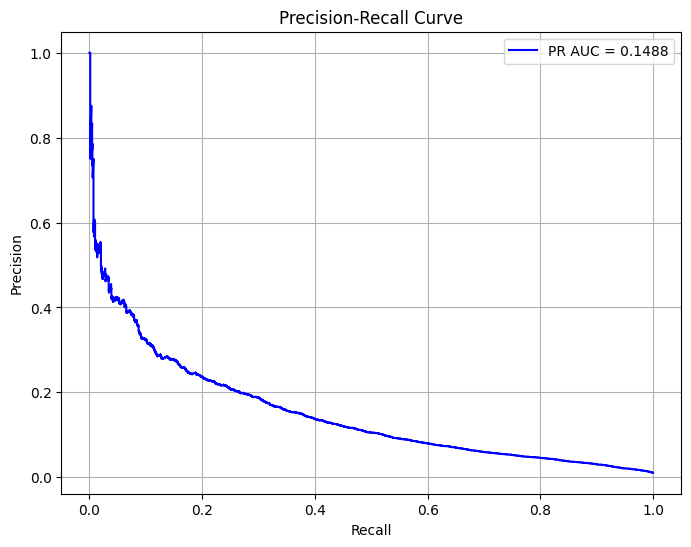

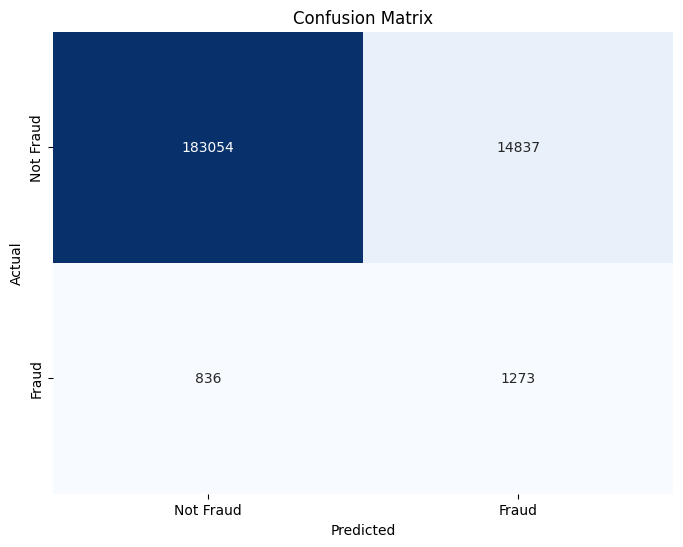

{'PREDS': array([0.15658806, 0.01093273, 0.04235698, ..., 0.23335037, 0.06059485,
       0.04973919], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(183054), 'FP': np.int64(14837), 'FN': np.int64(836), 'TP': np.int64(1273), 'TPR': np.float64(0.6036036036036037), 'FPR': np.float64(0.07497561789065697), 'ROC AUC': np.float64(0.8889036262446771), 'Confusion Matrix': array([[183054,  14837],
       [   836,   1273]]), 'ROC Curve': (array([0.        , 0.        , 0.        , ..., 0.99901461, 0.99901461,
       1.        ]), array([0.00000000e+00, 4.74158369e-04, 1.42247511e-03, ...,
       9.99525842e-01, 1.00000000e+00, 1.00000000e+00])), 'PRECISION': array([0.010545  , 0.01054505, 0.01054511, ..., 1.        , 1.        ,
       1.        ])}


In [129]:
baseline_perfomance = evaluate_model_performance(default_model3, 
                                              X_test, y_test, 
                                              threshold=0.7,
                                              plot_pr_curve=True, plot_confusion_matrix=True)
print(baseline_perfomance)

In [130]:
compare = pd.DataFrame({
    'y':y_test.fraud_bool,
    'y_hat':baseline_perfomance["PREDS_BOOL"]
})

compare[compare.y==1].sum()

y        2109
y_hat    1273
dtype: int64

In [132]:
feature_importance = default_model3.get_score(fmap='', importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance_df = pd.DataFrame(data=values, 
                                     index=keys, 
                                     columns=["score"])\
.sort_values(by = "score", ascending=False)
feature_importance_df

,score
scaled_name_email_similarity,115.0
scaled_current_address_months_count,105.0
scaled_velocity_4w,96.0
scaled_credit_risk_score,92.0
scaled_intended_balcon_amount,80.0
scaled_bank_branch_count_8w,70.0
scaled_zip_count_4w,69.0
scaled_date_of_birth_distinct_emails_4w,65.0
scaled_session_length_in_minutes,64.0
scaled_days_since_request,62.0


# Baseline model 4 - use binning+target encoding; without smotenc; use xgboost scale_pos_weight

In [133]:
print("Reading training and test data...")
X_train = pd.read_csv(f"{home_dir}/data/target_encoded_x_train.csv", index_col=0)
y_train = pd.read_csv(f"{home_dir}/data/target_encoded_y_train.csv", index_col=0)
X_test = pd.read_csv(f"{home_dir}/data/target_encoded_x_test.csv", index_col=0)
y_test = pd.read_csv(f"{home_dir}/data/target_encoded_y_test.csv", index_col=0)

# X_train_smote = pd.read_csv(f"{parent_dir}/data/x_train_data_smote.csv", index_col=0)
# y_train_smote = pd.read_csv(f"{parent_dir}/data/y_train_data_smote.csv", index_col=0)

Reading training and test data...


In [134]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [135]:
# scale_pos_weight = count(negative examples)/count(Positive examples) or 

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()

weight_ratio = int(round(neg_count/ pos_count))
print("Weight Ratio:", weight_ratio)

default_model4= XGBClassifier(scale_pos_weight=weight_ratio, eval_metric='aucpr')
default_params4 = default_model4.get_params()
print(default_params4)

Weight Ratio: 89
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 89, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [136]:
default_model4 = fit_model(default_params4, dtrain, dtest)

[0]	training-aucpr:0.07713	testing-aucpr:0.06979
[2]	training-aucpr:0.11074	testing-aucpr:0.09690
[4]	training-aucpr:0.12633	testing-aucpr:0.10858
[6]	training-aucpr:0.14268	testing-aucpr:0.11851
[8]	training-aucpr:0.15209	testing-aucpr:0.12241
[10]	training-aucpr:0.16162	testing-aucpr:0.13027
[12]	training-aucpr:0.17166	testing-aucpr:0.13607
[14]	training-aucpr:0.17811	testing-aucpr:0.13939
[16]	training-aucpr:0.18375	testing-aucpr:0.14560
[18]	training-aucpr:0.18783	testing-aucpr:0.14517
[20]	training-aucpr:0.19193	testing-aucpr:0.14618
[22]	training-aucpr:0.19447	testing-aucpr:0.14802
[24]	training-aucpr:0.19690	testing-aucpr:0.14999
[26]	training-aucpr:0.20057	testing-aucpr:0.15172
[28]	training-aucpr:0.20327	testing-aucpr:0.15245
[30]	training-aucpr:0.20448	testing-aucpr:0.15295
[32]	training-aucpr:0.20690	testing-aucpr:0.15369
[34]	training-aucpr:0.20977	testing-aucpr:0.15334
[36]	training-aucpr:0.21275	testing-aucpr:0.15399
[38]	training-aucpr:0.21363	testing-aucpr:0.15391
[40]	

Recall (TPR): 0.6022
False Positive Rate (FPR): 0.0724
ROC AUC: 0.89186
PR AUC: 0.15261


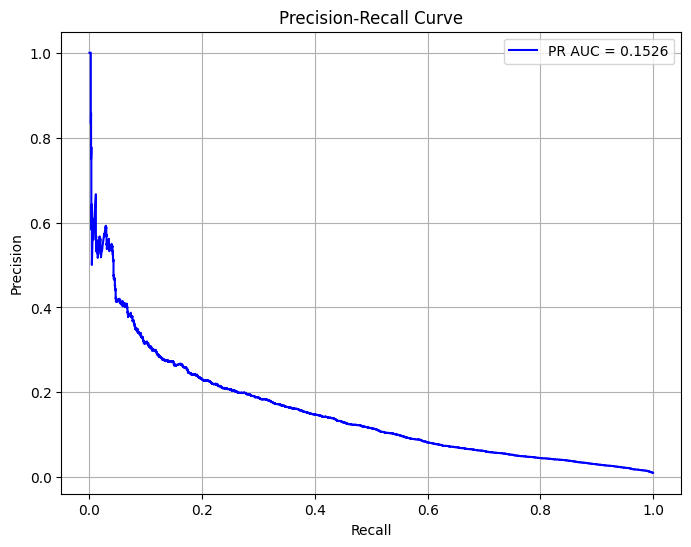

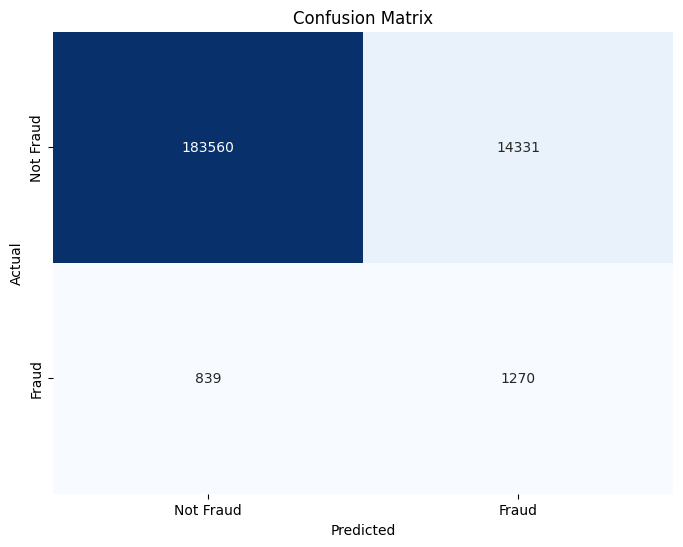

{'PREDS': array([0.04917968, 0.00710161, 0.06131972, ..., 0.20389551, 0.18905398,
       0.03175173], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(183560), 'FP': np.int64(14331), 'FN': np.int64(839), 'TP': np.int64(1270), 'TPR': np.float64(0.602181128496918), 'FPR': np.float64(0.0724186547139587), 'ROC AUC': np.float64(0.8918597487700788), 'Confusion Matrix': array([[183560,  14331],
       [   839,   1270]]), 'ROC Curve': (array([0.        , 0.        , 0.        , ..., 0.99710447, 0.99711457,
       1.        ]), array([0.00000000e+00, 4.74158369e-04, 2.37079184e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])), 'PRECISION': array([0.010545  , 0.01054505, 0.01054511, ..., 1.        , 1.        ,
       1.        ])}


In [137]:
baseline_perfomance = evaluate_model_performance(default_model4, 
                                              X_test, y_test, 
                                              threshold=0.7,
                                              plot_pr_curve=True, plot_confusion_matrix=True)
print(baseline_perfomance)

In [138]:
compare = pd.DataFrame({
    'y':y_test.fraud_bool,
    'y_hat':baseline_perfomance["PREDS_BOOL"]
})

compare[compare.y==1].sum()

y        2109
y_hat    1270
dtype: int64

In [140]:
feature_importance = default_model4.get_score(fmap='', importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance_df = pd.DataFrame(data=values, 
                                     index=keys, 
                                     columns=["score"])\
.sort_values(by = "score", ascending=False)
feature_importance_df

,score
scaled_credit_risk_score,172.0
scaled_name_email_similarity,169.0
scaled_current_address_months_count,145.0
scaled_intended_balcon_amount,143.0
scaled_velocity_4w,142.0
scaled_days_since_request,123.0
scaled_zip_count_4w,121.0
scaled_bank_branch_count_8w,117.0
scaled_velocity_24h,117.0
scaled_velocity_6h,112.0


# Random search

In [36]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
with open(out_file, 'w', newline='') as of_connection:
    writer = csv.writer(of_connection)
    # Write column names
    headers = ['score', 'params', 'iterations']
    writer.writerow(headers)

In [38]:
def random_search(dtrain, out_file, iteration=1):
    best_auc = 0
    best_params = {}
    results = pd.DataFrame(columns = ['score', 'params', 'iterations'], 
                          index = list(range(iteration)))
    
    for i in range(iteration):
        np.random.seed(None)
        param_grid = {
            'eta': np.random.uniform(0.01, 0.6),
            'lambda': np.random.uniform(0.01, 0.2),
            'alpha': np.random.uniform(0.01, 0.2),
            'gamma': np.random.uniform(0, 20),
            'max_depth': np.random.randint(3, 15),
            'subsample': np.random.uniform(0.5, 1),
            'colsample_bytree': np.random.uniform(0.5, 1),
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'min_child_weight': np.random.uniform(0.8, 1.2)
        }
        
        print(f"Iteration {i} - Params: {param_grid}")

        random_cv = objective(param_grid, dtrain, iteration=i)
        results.loc[i, :] = {
            "score": random_cv[1], 
            "params": random_cv[2], 
            "iterations": random_cv[3]
        }

        with open(out_file, 'a', newline='') as of_connection:
            writer = csv.writer(of_connection)
            writer.writerow([random_cv[1], random_cv[2], random_cv[3]])
    
        auc_score = random_cv[1]
        
        if auc_score > best_auc:
            best_auc = auc_score
            best_params = random_cv[2]

    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results, best_params, best_auc

In [39]:
randome_search_result, random_best_params, random_best_auc = random_search(dtrain, out_file, iteration=100)

Iteration 0 - Params: {'eta': 0.46721805598925914, 'lambda': 0.09510100434212998, 'alpha': 0.17309968933620054, 'gamma': 11.608830146061887, 'max_depth': 13, 'subsample': 0.5565887710699626, 'colsample_bytree': 0.8306399829150326, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'min_child_weight': 0.9100921662931908}
[0]	train-auc:0.98577+0.00023	test-auc:0.98518+0.00057
[2]	train-auc:0.99240+0.00016	test-auc:0.99193+0.00023
[4]	train-auc:0.99502+0.00021	test-auc:0.99463+0.00024
[6]	train-auc:0.99642+0.00013	test-auc:0.99602+0.00024
[8]	train-auc:0.99705+0.00008	test-auc:0.99666+0.00018
[10]	train-auc:0.99748+0.00008	test-auc:0.99709+0.00016
[12]	train-auc:0.99773+0.00006	test-auc:0.99733+0.00012
[14]	train-auc:0.99791+0.00005	test-auc:0.99750+0.00010
[16]	train-auc:0.99801+0.00005	test-auc:0.99760+0.00011
[18]	train-auc:0.99810+0.00004	test-auc:0.99767+0.00011
[20]	train-auc:0.99817+0.00003	test-auc:0.99773+0.00012
[22]	train-auc:0.99822+0.00002	test-auc:0.99778+0.00011
[24]	tra

In [79]:
randome_search_result

,index,score,params,iterations
0,37,0.998774,"{'eta': 0.04218102577876563, 'lambda': 0.07314...",37
1,58,0.998625,"{'eta': 0.06210061367411263, 'lambda': 0.02589...",58
2,20,0.998526,"{'eta': 0.3577296217325374, 'lambda': 0.016852...",20
3,30,0.998493,"{'eta': 0.12535977965991643, 'lambda': 0.08334...",30
4,48,0.998464,"{'eta': 0.28346872916658755, 'lambda': 0.02814...",48
5,83,0.99844,"{'eta': 0.42979356309389144, 'lambda': 0.03417...",83
6,80,0.998436,"{'eta': 0.1859567625540228, 'lambda': 0.079890...",80
7,72,0.998407,"{'eta': 0.049640421806098387, 'lambda': 0.0301...",72
8,9,0.99838,"{'eta': 0.04131566091904619, 'lambda': 0.02979...",9
9,65,0.998368,"{'eta': 0.26497479461979584, 'lambda': 0.09768...",65


In [87]:
pd.set_option('display.max_rows', 100)
params_pd = randome_search_result['params'].apply(pd.Series)
pd.concat([params_pd, randome_search_result.drop('params', axis=1)], axis=1)

,eta,lambda,alpha,gamma,max_depth,subsample,colsample_bytree,objective,eval_metric,min_child_weight,index,score,iterations
0,0.042181,0.073145,0.168477,2.777432,13,0.965933,0.663497,binary:logistic,auc,0.929162,37,0.998774,37
1,0.062101,0.025897,0.149256,5.056566,14,0.977984,0.506966,binary:logistic,auc,0.911483,58,0.998625,58
2,0.357730,0.016853,0.142712,1.114559,14,0.707550,0.922462,binary:logistic,auc,1.102070,20,0.998526,20
3,0.125360,0.083349,0.118283,5.909110,13,0.975951,0.844218,binary:logistic,auc,0.934856,30,0.998493,30
4,0.283469,0.028141,0.142405,4.991860,14,0.975174,0.813608,binary:logistic,auc,0.967171,48,0.998464,48
5,0.429794,0.034172,0.022967,0.656724,13,0.828682,0.627988,binary:logistic,auc,0.934264,83,0.99844,83
6,0.185957,0.079891,0.083599,6.162646,14,0.772278,0.581528,binary:logistic,auc,1.103506,80,0.998436,80
7,0.049640,0.030196,0.158776,6.566767,13,0.525332,0.559221,binary:logistic,auc,1.077319,72,0.998407,72
8,0.041316,0.029795,0.187837,5.691572,9,0.641382,0.782052,binary:logistic,auc,0.839949,9,0.99838,9
9,0.264975,0.097686,0.171042,3.485444,12,0.589379,0.899015,binary:logistic,auc,0.878113,65,0.998368,65


In [56]:
print(random_best_params, random_best_auc)

{'eta': 0.04218102577876563, 'lambda': 0.07314480556578744, 'alpha': 0.16847719363993527, 'gamma': 2.777432343987718, 'max_depth': 13, 'subsample': 0.9659334022938243, 'colsample_bytree': 0.6634970890418102, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'min_child_weight': 0.9291615704079811} 0.9987743581278223


In [62]:
final_random_search_model = fit_model(random_best_params, dtrain, dtest)

[0]	training-auc:0.97260	testing-auc:0.76197
[2]	training-auc:0.99075	testing-auc:0.79368
[4]	training-auc:0.99353	testing-auc:0.80642
[6]	training-auc:0.99411	testing-auc:0.81737
[8]	training-auc:0.99418	testing-auc:0.82363
[10]	training-auc:0.99462	testing-auc:0.82821
[12]	training-auc:0.99473	testing-auc:0.82951
[14]	training-auc:0.99508	testing-auc:0.83103
[16]	training-auc:0.99532	testing-auc:0.83150
[18]	training-auc:0.99541	testing-auc:0.83203
[20]	training-auc:0.99550	testing-auc:0.83392
[22]	training-auc:0.99567	testing-auc:0.83452
[24]	training-auc:0.99577	testing-auc:0.83606
[26]	training-auc:0.99591	testing-auc:0.83583
[28]	training-auc:0.99606	testing-auc:0.83735
[30]	training-auc:0.99616	testing-auc:0.83748
[32]	training-auc:0.99637	testing-auc:0.83797
[34]	training-auc:0.99652	testing-auc:0.83846
[36]	training-auc:0.99658	testing-auc:0.83966
[38]	training-auc:0.99671	testing-auc:0.84022
[40]	training-auc:0.99682	testing-auc:0.84076
[42]	training-auc:0.99689	testing-auc:0

Recall (TPR): 0.1043
False Positive Rate (FPR): 0.0029
ROC AUC: 0.88509


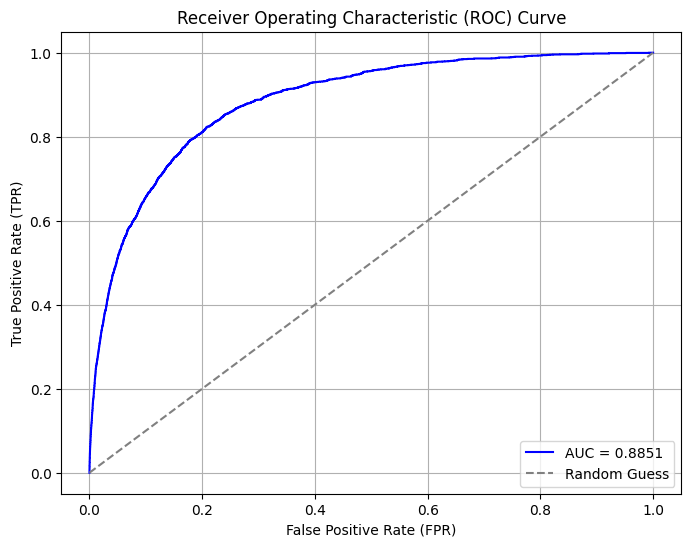

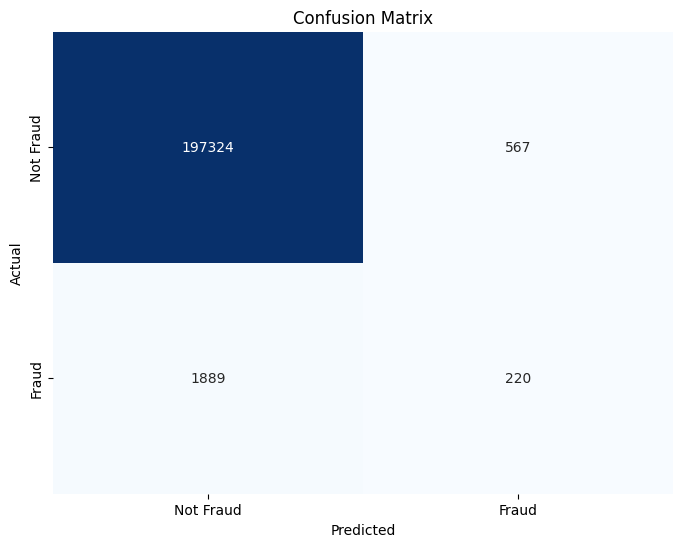

{'PREDS': array([0.00140303, 0.00021948, 0.00309521, ..., 0.00209311, 0.0021742 ,
       0.00171894], dtype=float32), 'PREDS_BOOL': array([0, 0, 0, ..., 0, 0, 0]), 'TN': np.int64(197324), 'FP': np.int64(567), 'FN': np.int64(1889), 'TP': np.int64(220), 'TPR': np.float64(0.10431484115694642), 'FPR': np.float64(0.0028652136782370092), 'ROC AUC': np.float64(0.8850891805343871), 'Confusion Matrix': array([[197324,    567],
       [  1889,    220]]), 'ROC Curve': (array([0.        , 0.        , 0.        , ..., 0.99296077, 0.99297088,
       1.        ]), array([0.00000000e+00, 4.74158369e-04, 9.48316738e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))}


In [77]:
random_search_perfomance = evaluate_model_performance(final_random_search_model, 
                                              X_test, y_test, 
                                              threshold=0.4, 
                                              plot_roc_curve=True, plot_confusion_matrix=True)
print(random_search_perfomance)

## Grid search

In [20]:
import itertools
grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))


def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

In [23]:
N_FOLD = 10
D_TRAIN = xgb.DMatrix(X_train, label=y_train)
MAX_EVALS = 30
param_grid = {
    'eta': list(np.logspace(np.log10(0.001), np.log10(0.6), base = 10, num = 500)),
    'lambda': list(np.linspace(0.01, 0.2, num = 100)),
    'alpha': list(np.linspace(0.01, 0.2, 100)),
    'gamma': list(np.linspace(0, 20, 100)),
    'max_depth': list(range(3, 15, 1)),
    'subsample': list(np.linspace(0.5, 1, 5)),
    'colsample_bytree': list(np.linspace(0.5, 1, 5)),
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'min_child_weight': list(np.linspace(0.8, 1.2, 5))
}
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.95893

The best hyperparameters were:
{'alpha': np.float64(0.01),
 'colsample_bytree': np.float64(0.5),
 'eta': np.float64(0.001),
 'eval_metric': 'auc',
 'gamma': np.float64(0.0),
 'lambda': np.float64(0.01),
 'max_depth': 3,
 'min_child_weight': np.float64(0.8),
 'n_estimators': 6,
 'objective': 'binary:logistic',
 'subsample': np.float64(0.5)}


In [25]:
grid_search_params = grid_results.loc[0, 'params']
# model_grid_search = XGBClassifier(**grid_search_params, random_state=42)

In [61]:
dtest = xgb.DMatrix(X_test, label=y_test)

grid_search_final_model = xgb.train(
    params=grid_search_params,
    dtrain=D_TRAIN,
    num_boost_round=10000,
    early_stopping_rounds=5,
    evals=[(dtrain, 'training'), (dtest, 'testing')],
    maximize=True,
    verbose_eval=True
)

[0]	training-auc:0.83741	testing-auc:0.69655
[1]	training-auc:0.93393	testing-auc:0.77610
[2]	training-auc:0.93762	testing-auc:0.79139
[3]	training-auc:0.94848	testing-auc:0.80987
[4]	training-auc:0.95741	testing-auc:0.81919
[5]	training-auc:0.95891	testing-auc:0.81488
[6]	training-auc:0.95633	testing-auc:0.81604
[7]	training-auc:0.95479	testing-auc:0.81694
[8]	training-auc:0.95478	testing-auc:0.81751
[9]	training-auc:0.95614	testing-auc:0.81744


In [62]:
grid_search_final_model.attributes()

{'best_iteration': '4', 'best_score': '0.8191889736158259'}

In [71]:
grid_preds = grid_search_final_model.predict(dtest)
threshold = 0.5
y_pred = (grid_preds >= threshold).astype(int)
grid_auc = roc_auc_score(y_test, grid_preds)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Recall (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f'ROC AUC: {grid_auc:.5f}')

Recall (TPR): 0.5235
False Positive Rate (FPR): 0.0994
ROC AUC: 0.81744
